In [ ]:
import binascii
import math
import random
import re
import string

import scipy.optimize as opt
import collections

In [2]:
import numpy as np


def invert_shingles(shingled_documents):
    # initialize list for tuples
    doc_items_pair = []
    # initialize list for document ids
    doc_ids = []
    # for each document in input
    for shingled_doc in shingled_documents:
        # append document id to list
        doc_id, items = shingled_doc
        doc_ids.append(doc_id)
        for item in items:
            # append (item, doc_id) tuple
            doc_items_pair.append((item, doc_id))
    # sort tuple list
    doc_items_pair.sort(key=lambda x: x[0])
    # return sorted tuple list, and document list
    return doc_items_pair, doc_ids


exclude = set(string.punctuation)


def parse_data(filename):
    ans = []
    with open("data/" + filename, "r") as f:
        # read lines from filename
        for line in f:
            if line[-1] == "\n":
                line = line[:-1]
            m = re.search(r't\d+', line)
            doc_id = m.group()
            doc = line[len(doc_id):].lower().replace(" ", "")
            doc = ''.join(ch for ch in doc if ch not in exclude)
            ans.append((doc_id, doc))
    return ans


def shingle_document(string, k):
    shingles_in_doc = set()
    for index in range(len(string) - k + 1):
        shingles = string[index:index + k]
        crc = binascii.crc32(bytes(shingles, encoding="utf-8"))
        shingles_in_doc.add(crc)
    return shingles_in_doc


def get_shingled_list(docs):
    ans = []
    for doc in docs:
        doc_id, content = doc
        ans.append((doc_id, shingle_document(content, K)))
    return ans


def make_minhash_signature(shingled_data, num_hashes):
    inv_index, doc_ids = invert_shingles(shingled_data)
    num_docs = len(doc_ids)

    # initialize the signature matrix with infinity in every entry
    sig_matrix = np.full([num_hashes, num_docs], np.inf)

    # generate hash functions
    hash_funcs = make_hashes(num_hashes)

    column_cache = doc_ids_column_cache(doc_ids)
    # iterate over each non-zero entry of the characteristic matrix
    for row, doc_id in inv_index:
        # update signature matrix if needed
        col = column_cache[doc_id]
        for i, hash_fn in enumerate(hash_funcs):
            sig_matrix[i][col] = min(hash_fn(row), sig_matrix[i][col])
    return sig_matrix, doc_ids


def doc_ids_column_cache(doc_ids: list):
    cache = {}
    for i, doc_id in enumerate(doc_ids):
        cache[doc_id] = i
    return cache


In [3]:
def make_hashes(num_hash):
    fns = []
    for _ in range(num_hash):
        fns.append(make_random_hash_fn())
    return fns

In [4]:

def make_random_hash_fn(p=2 ** 33 - 355, m=4294967295):
    a = random.randint(1, p - 1)
    b = random.randint(0, p - 1)
    return lambda x: ((a * x + b) % p) % m

In [5]:
def _choose_nbands(t, n):
    def _error_fun(x):
        cur_t = (1 / x[0]) ** (x[0] / n)
        return (t - cur_t) ** 2

    opt_res = opt.minimize(_error_fun, x0=(10), method='Nelder-Mead')
    b = int(math.ceil(opt_res['x'][0]))
    r = int(n / b)
    final_t = (1 / b) ** (1 / r)
    return b, final_t

In [6]:
def _make_vector_hash(num_hashes, m=4294967295):
    hash_fns = make_hashes(num_hashes)

    def _f(vec):
        acc = 0
        for i in range(len(vec)):
            h = hash_fns[i]
            acc += h(vec[i])
        return acc % m

    return _f

In [7]:
def do_lsh(minhash_sigmatrix, numhashes, docids, threshold):
    # choose the number of bands, and rows per band to use in LSH
    b, _ = _choose_nbands(threshold, numhashes)
    r = int(numhashes / b)

    narticles = len(docids)

    # generate a random hash function that takes vectors of lenght r as input
    hash_func = _make_vector_hash(r)

    # setup the list of hashtables, will be populated with one hashtable per band
    buckets = []

    # fill hash tables for each band
    for band in range(b):
        # figure out which rows of minhash signature matrix to hash for this band
        start_index = int(band * r)
        end_index = min(start_index + r, numhashes)

        # initialize hashtable for this band
        cur_buckets = collections.defaultdict(list)

        for j in range(narticles):
            # THIS IS WHAT YOU NEED TO IMPLEMENT
            hashes = minhash_sigmatrix[start_index:end_index, j]
            cur_buckets[hash_func(hashes)].append(j)

        # add this hashtable to the list of hashtables
        buckets.append(cur_buckets)

    return buckets

In [8]:
TRAIN = "articles_10000.train"
TRUTH = "articles_10000.truth"

K = 10
num_hashes = 100
doc_data = parse_data(TRAIN)
shingled_list = get_shingled_list(doc_data)
sig_matrix, doc_ids = make_minhash_signature(shingled_list, num_hashes)

truth_data = parse_data(TRUTH)

In [9]:
import itertools


def get_truth_cache(truth_tuples, doc_ids):
    cache = []
    ids_column_cache = doc_ids_column_cache(doc_ids)
    for (id1, id2) in truth_tuples:
        cache.append((ids_column_cache[id1], ids_column_cache[id2]))
    return cache


def find_pairs(buckets):
    pair_tuple = list()
    for row in buckets:
        all_items = [x for x in row.values() if len(x) > 1]
        for ind in all_items:
            pair_tuple.extend(list(itertools.combinations(tuple(ind), 2)))

        return set(pair_tuple)


truth_cache = get_truth_cache(truth_data, doc_ids)

In [10]:
def test_threshold(threshold):
    tuples = []
    r = 2
    for t in np.arange(0.1, threshold, 0.05):
        buckets = do_lsh(sig_matrix, len(sig_matrix), doc_ids, t)
        predicted = list(find_pairs(buckets))
        n = len(doc_ids)
        print("threshold = " + str(t))
        print("Len of Predicted: " + str(len(predicted)))
        print("Len of Truth: " + str(len(truth_cache)))

        TP = len([x for x in truth_cache if x in predicted])
        print("TP = " + str(TP))

        FP = len(predicted) - TP
        print("FP = " + str(FP))

        ALL = math.factorial(n) / (math.factorial(n - r) * math.factorial(r))

        TN = ALL - len(predicted) - len(truth_cache) + TP
        print("TN = " + str(TN))

        FN = len(truth_cache) - TP
        print("FN = " + str(FN))

        sensitivity = TP / (TP + FN)  # TP/(TP + FN)
        specificity = TN / (TN + FP)  # TN/(TN + FP)

        tuples.append((t, sensitivity, specificity))
    return tuples

threshold = 0.1
Len of Predicted: 44575
Len of Truth: 80
TP = 40
FP = 44535
TN = 49950385.0
FN = 40
threshold = 0.15000000000000002
Len of Predicted: 1425
Len of Truth: 80
TP = 40
FP = 1385
TN = 49993535.0
FN = 40
threshold = 0.20000000000000004
Len of Predicted: 1425
Len of Truth: 80
TP = 40
FP = 1385
TN = 49993535.0
FN = 40
threshold = 0.25000000000000006
Len of Predicted: 1425
Len of Truth: 80
TP = 40
FP = 1385
TN = 49993535.0
FN = 40
threshold = 0.30000000000000004
Len of Predicted: 1425
Len of Truth: 80
TP = 40
FP = 1385
TN = 49993535.0
FN = 40
threshold = 0.3500000000000001
Len of Predicted: 415
Len of Truth: 80
TP = 40
FP = 375
TN = 49994545.0
FN = 40
threshold = 0.40000000000000013
Len of Predicted: 415
Len of Truth: 80
TP = 40
FP = 375
TN = 49994545.0
FN = 40
threshold = 0.45000000000000007
Len of Predicted: 80
Len of Truth: 80
TP = 40
FP = 40
TN = 49994880.0
FN = 40
threshold = 0.5000000000000001
Len of Predicted: 80
Len of Truth: 80
TP = 40
FP = 40
TN = 49994880.0
FN = 40
th

/var/folders/z3/5qvbk77s3bs10cd05_tp_fyw0000gn/T/ipykernel_60861/3610618223.py:3: RuntimeWarning: invalid value encountered in double_scalars
  cur_t = (1 / x[0]) ** (x[0] / n)


threshold = 0.9500000000000003
Len of Predicted: 66
Len of Truth: 80
TP = 35
FP = 31
TN = 49994889.0
FN = 45


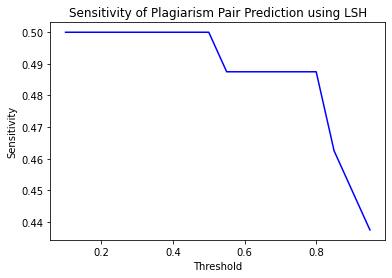

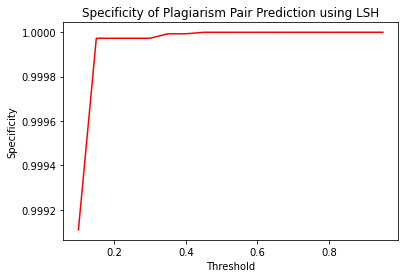

In [11]:

import pandas as pd
import matplotlib.pyplot as plt

data = test_threshold(1)
dt = pd.DataFrame(data, columns=["threshold", "sensitivity", "specificity"])
plt.plot(dt.threshold, dt.sensitivity, color="blue")
plt.title("Sensitivity of Plagiarism Pair Prediction using LSH")
plt.xlabel("Threshold")
plt.ylabel("Sensitivity")
plt.show()

plt.plot(dt.threshold, dt.specificity, color="Red")
plt.title("Specificity of Plagiarism Pair Prediction using LSH")
plt.xlabel("Threshold")
plt.ylabel("Specificity")
plt.show()